In [1]:
import pickle
import os
import glob
import random
import sys
import pandas as pd
import numpy as np

if not os.path.abspath ("../modules") in sys.path:
    sys.path.append (os.path.abspath ("../modules"))
import hpmodels

In [2]:
PICKLED_DIR = "../data/hyperparameters-search/001/"

In [3]:
# Read the innovations
with open ("../data/data-v1.001.pkl", 'rb') as fin:
    idx, iidx, cascades, innovs = pickle.load (fin)

In [4]:
df = pd.read_csv (os.path.join (PICKLED_DIR, "hyperparams.csv"), sep=",")
print (df)

   filename  bandwidth  l2_coeff
0     1.pkl       0.25     0.001
1     2.pkl       0.25     0.010
2     3.pkl       0.25     0.100
3     4.pkl       0.25     1.000
4     5.pkl       0.25    10.000
5     6.pkl       0.25   100.000
6     7.pkl       0.25  1000.000
7     8.pkl       0.50     0.001
8     9.pkl       0.50     0.010
9    10.pkl       0.50     0.100
10   11.pkl       0.50     1.000
11   12.pkl       0.50    10.000
12   13.pkl       0.50   100.000
13   14.pkl       0.50  1000.000
14   15.pkl       1.00     0.001
15   16.pkl       1.00     0.010
16   17.pkl       1.00     0.100
17   18.pkl       1.00     1.000
18   19.pkl       1.00    10.000
19   20.pkl       1.00   100.000
20   21.pkl       1.00  1000.000
21   22.pkl       2.00     0.001
22   23.pkl       2.00     0.010
23   24.pkl       2.00     0.100
24   25.pkl       2.00     1.000
25   26.pkl       2.00    10.000
26   27.pkl       2.00   100.000
27   28.pkl       2.00  1000.000
28   29.pkl       4.00     0.001
29   30.pk

In [5]:
seed = 23
train_percent = 0.8
random.seed (seed)
random.shuffle (cascades)
random.seed (seed)
random.shuffle (innovs)
train_cascades = cascades[:int((len(cascades)+1)*train_percent)]
test_cascades = cascades[int((len(cascades)+1)*train_percent):]

In [7]:
heldout_objectives = list ()
for filename in glob.glob (f"{PICKLED_DIR}/*.pkl"):
    with open (filename, "rb") as fin:
        result = pickle.load (fin)
        bandwidth = float(df[df["filename"] == os.path.basename(filename)].bandwidth.item())
        heldout_log_likelihood = hpmodels.DCHP.log_likelihood_many_cascades (result.x,
                                                                             test_cascades,
                                                                             hpmodels.DCHP.log_likelihood_single_cascade,
                                                                             bandwidth=bandwidth,
                                                                             dims=len(idx),
                                                                             sign=1.0)
        l2_coeff = float(df[df["filename"] == os.path.basename(filename)]["l2_coeff"].item())
        
        heldout_objectives.append ((bandwidth, l2_coeff, heldout_log_likelihood))
        
heldout_objectives = pd.DataFrame (heldout_objectives, columns=["bandwidth", "l2-coeff", "objective"])

In [8]:
heldout_objectives[heldout_objectives.objective == heldout_objectives.objective.max()]

,bandwidth,l2-coeff,objective
11,0.5,0.01,371.441743


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

/hg191/sandeep/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/hg191/sandeep/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/hg191/sandeep/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/hg191/sandeep/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWar

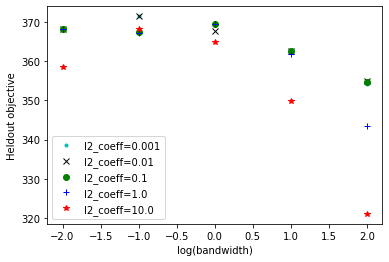

In [49]:
for color_string, l2_coeff in [("c.", 0.001), ("kx", 0.01), ("go", 0.1), ("b+", 1.0), ("r*", 10.0)]:
    plt.plot(np.log2(heldout_objectives[heldout_objectives["l2-coeff"] == l2_coeff].bandwidth), heldout_objectives[heldout_objectives["l2-coeff"] == l2_coeff].objective, color_string, label=f"l2_coeff={l2_coeff}")

plt.xlabel ("log(bandwidth)")
plt.ylabel ("Heldout objective")
plt.legend ()